In [46]:
import YouTube_Data_Story as ds
import YouTube_Data_Wrangling as dw
from matplotlib.gridspec import GridSpec
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import requests
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler

In [88]:
df_usa=dw.combined_usa_mx_df[dw.combined_usa_mx_df.country=='USA']
df_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35726 entries, 0 to 40900
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trending_date           35726 non-null  datetime64[ns]
 1   title                   35726 non-null  object        
 2   category_id             35726 non-null  int64         
 3   publish_time            35726 non-null  datetime64[ns]
 4   views                   35726 non-null  int64         
 5   likes                   35726 non-null  int64         
 6   dislikes                35726 non-null  int64         
 7   comment_count           35726 non-null  int64         
 8   comments_disabled       35726 non-null  bool          
 9   ratings_disabled        35726 non-null  bool          
 10  video_error_or_removed  35726 non-null  bool          
 11  category_name           35726 non-null  object        
 12  country                 35726 non-null  object

(array([3.5201e+04, 3.3500e+02, 1.1400e+02, 3.0000e+01, 1.7000e+01,
        1.0000e+01, 7.0000e+00, 4.0000e+00, 3.0000e+00, 5.0000e+00]),
 array([5.49000000e+02, 2.17755017e+07, 4.35504544e+07, 6.53254071e+07,
        8.71003598e+07, 1.08875312e+08, 1.30650265e+08, 1.52425218e+08,
        1.74200171e+08, 1.95975123e+08, 2.17750076e+08]),
 <a list of 10 Patch objects>)

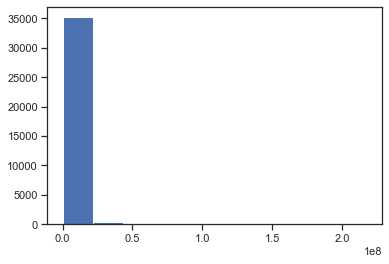

In [112]:
plt.hist(df_usa['views'])

(array([3.5657e+04, 5.3000e+01, 6.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00]),
 array([      0.,  167442.,  334884.,  502326.,  669768.,  837210.,
        1004652., 1172094., 1339536., 1506978., 1674420.]),
 <a list of 10 Patch objects>)

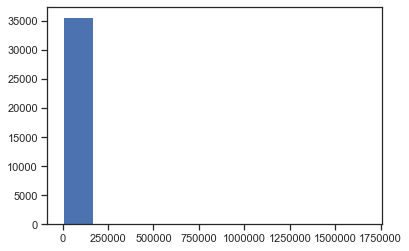

In [113]:
plt.hist(df_usa['dislikes'])

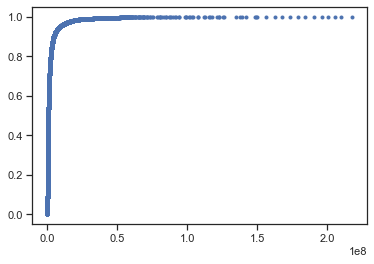

In [114]:
def ecdf(data):
    x=np.sort(data)
    y=np.arange(1,len(x)+1)/len(x)
    _=plt.plot(x,y,marker='.',linestyle='none')
ecdf(df_usa['views'])

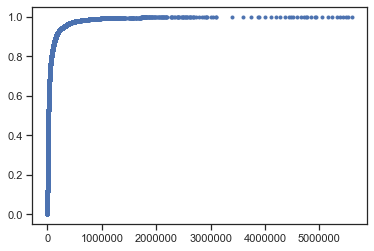

In [115]:
ecdf(df_usa['likes'])

In [49]:
category_views=dw.combined_usa_mx_df[['category_name','views']]

In [60]:
category_views.category_name.value_counts(normalize=True)

Entertainment           0.3
People & Blogs          0.1
Music                   0.1
Howto & Style           0.1
Sports                  0.1
News & Politics         0.1
Comedy                  0.1
Film & Animation        0.0
Science & Technology    0.0
Education               0.0
Gaming                  0.0
Pets & Animals          0.0
Autos & Vehicles        0.0
Travel & Events         0.0
Shows                   0.0
Nonprofits & Activism   0.0
Name: category_name, dtype: float64

In [52]:
category_views.groupby('category_name').mean()

,views
category_name,
Autos & Vehicles,"928,767.9"
Comedy,"1,130,144.5"
Education,"552,645.9"
Entertainment,"974,222.1"
Film & Animation,"2,136,180.0"
Gaming,"1,393,765.7"
Howto & Style,"641,640.5"
Music,"4,541,969.4"
News & Politics,"347,779.0"


In [68]:
views_cat_mx_2017_df=ds.views_df_2017_mx.drop(['Nonprofits & Activism'])

In [98]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat=np.corrcoef(x,y)
    
    # Return entry [0,1]
    return corr_mat[0,1]

In [102]:
pearson_r(df_usa['views'],df_usa['comment_count'])

0.6013079187103455

In [ ]:
#From the datastory work done previously it is shown that the most %change in average views in USA was in "Shows" category (553% increase)


In [104]:
df_shows_usa=df_usa[df_usa.category_name=='Shows']

In [105]:
df_shows_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 7854 to 39296
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trending_date           52 non-null     datetime64[ns]
 1   title                   52 non-null     object        
 2   category_id             52 non-null     int64         
 3   publish_time            52 non-null     datetime64[ns]
 4   views                   52 non-null     int64         
 5   likes                   52 non-null     int64         
 6   dislikes                52 non-null     int64         
 7   comment_count           52 non-null     int64         
 8   comments_disabled       52 non-null     bool          
 9   ratings_disabled        52 non-null     bool          
 10  video_error_or_removed  52 non-null     bool          
 11  category_name           52 non-null     object        
 12  country                 52 non-null     object

(array([14.,  2.,  0.,  0.,  1.,  1.,  2.,  9., 13., 10.]),
 array([  36609.,  177543.,  318477.,  459411.,  600345.,  741279.,
         882213., 1023147., 1164081., 1305015., 1445949.]),
 <a list of 10 Patch objects>)

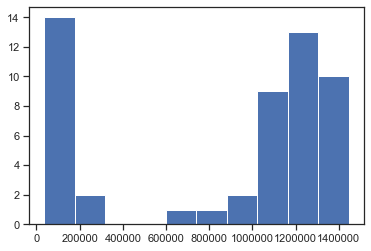

In [106]:
plt.hist(df_shows_usa['views'])

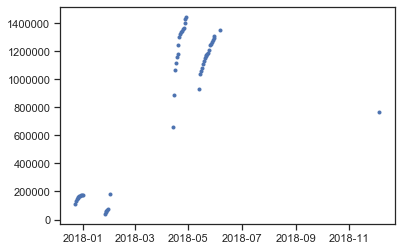

In [111]:
plt.plot(df_shows_usa['trending_date'],df_shows_usa['views'], marker='.', linestyle='None')